# Machine Learning
# TP3 Logistic Regression

## Generating Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

Here we generate two data set of 5000 samples. Each sample is a point distributed via a bivariate distribution. Mean are (0,0) and (1, 4). `[[1, .75], [.75, 1]]` is the covariance matrix. Both data set follows it. Samples generated with the first distribution are labelled $0$ and the others are labelled $1$.

Text(0, 0.5, '$y$')

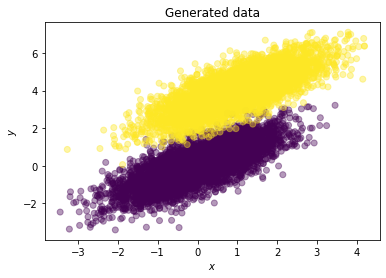

In [2]:
plt.figure(figsize=(6,4))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)
plt.title("Generated data")
plt.xlabel("$x$")
plt.ylabel("$y$")

## Picking a Link function

What is a link function ??

"Generalized linear models usually tranform a linear model of the predictors by using a [link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function). In logistic regression, the link function is the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). We can implement this really easily."

Anyway here the "link function" is simply the sigmoid one.

In [3]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

## Maximizing the Likelihood

$$P_{\rm model}(l({\bf x})=1) = \frac 1{1+\exp(-{\bf \theta} \cdot {\bf x})} \text{   &   } P_{\rm model}(l({\bf x})=0) = \frac {\exp(-{\bf \theta} \cdot {\bf x})}{1+\exp(-{\bf \theta} \cdot {\bf x})}$$


$${\rm Loss} =  \sum_{\rm dataset} - y_i {\bf \theta} \cdot {\bf x}_i  + \log{(1+\exp({\bf \theta} \cdot {\bf x}_i ))} $$


In [4]:
def loss_function(features, target, weights):
    scores = np.dot(features, weights) #theta * x_i
    a = np.dot(1 - target, scores)
    b = np.log(1 + np.exp(-scores))
    return np.sum(a + b)

In [5]:
w = np.array([0., 0.])
x = simulated_separableish_features
l = simulated_labels
print(loss_function(x, l, w))

6931.471805599453


Okay ?

## Calculating the gradient

In [6]:
def gradient(features, target, weights):
    scores = np.dot(features, weights)
    return features.T @(sigmoid(scores) - target)

In [7]:
print(gradient(x, l, w))

[ -2465.80841399 -10005.13673415]


Well...

## Building the Logistic Regression Function

We do a gradient descent to find the best value for the weight parameter $\theta$. Namely, $$\theta^{t+1} = \theta^t - \eta \nabla \mathrm{Loss}$$ where $\eta$ is a learning rate.

In [27]:
def logistic_regression(features, target, num_steps, learning_rate, 
                        add_intercept=True, verbose=False):
    
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        X = np.hstack((intercept, features))
    else:
        X = features
        
    weights = np.zeros(X.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(X, weights)
        predictions = sigmoid(scores)
        
        # Update weights 
        weights -= learning_rate * gradient(X, target, weights)
        
        # Print Loss every so often
        if verbose and step % 10000 == 0:
            print(loss_function(X, target, weights))
            
    return weights

Standard trick of adding "1" to a new column in the features array to fit with a $ax+b$ function instead of $ax$.

In [9]:
w = logistic_regression(x, l, num_steps = 50000, learning_rate = 5e-5,
                        add_intercept=False)

341594.0056370377
-76185.54536146758
-76185.54536146758
-76185.54536146758
-76185.54536146758


In [10]:
print(w)

[-0.68309377  1.0464493 ]


????

Let's look at a clean class from sklearn.

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
LR = LogisticRegression(penalty='none', fit_intercept=False)
LRclf = LR.fit(x, l)
print(LRclf.coef_)

[[-0.6830939   1.04644951]]


Good! Now what does that mean ?

In [13]:
w = logistic_regression(x, l, num_steps = 70000, learning_rate = 5e-5,
                        add_intercept=True)
print(w)

341594.0056370377
-543973469.0073197
-612302301.123827
-646732128.293126
-666937208.8541393
-679606742.3160272
-687838536.9025943
[-13.86069169  -4.97745522   8.15600611]


In [14]:
LR = LogisticRegression(penalty='none', fit_intercept=True)
LRclf = LR.fit(x, l)
print(LRclf.coef_)
print(LRclf.intercept_)

[[-5.05902155  8.28959202]]
[-14.09231079]


Not as good but similar. 

## What is the accuracy ?

What is it for ?

In [15]:
#def line(x, a, b, c):
#    return -x*b/c - a/c

#def myline(x):
#    return line(x, weights[0], weights[1], weights[2])

In [16]:
intercept = np.ones((x.shape[0], 1))
x_with_intercept = np.hstack((intercept, x))

final_scores = np.dot(x_with_intercept, w)
final_pred = np.round(sigmoid(final_scores))

In [17]:
accuracy = (final_pred == l).sum().astype(float) / len(l)
print("Accuracy: {0}".format(accuracy))

Accuracy: 0.9948


Quite good !

We check that the few mistakes are located between the clusters.

Text(0.5, 1.0, 'Misclassified points')

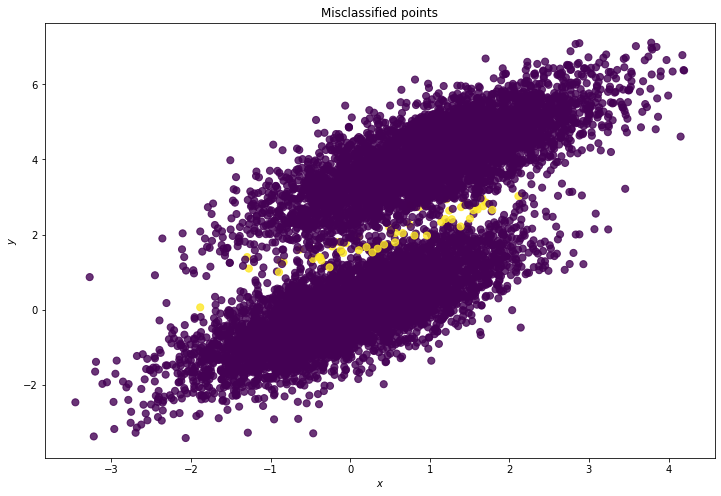

In [18]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.figure(figsize=(12, 8))
plt.scatter(x[:, 0], x[:, 1], c = final_pred!=l, alpha=.8, s=50)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Misclassified points")

## Bonus

In [57]:
# build a training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, l, 
                                                    test_size=0.2,
                                                    random_state=13)


#X_train_with_intercept = np.hstack((np.ones((X_train.shape[0], 1)), 
                                    X_train))
#X_test_with_intercept = np.hstack((np.ones((X_test.shape[0], 1)), 
                                    X_test))

In [67]:
LR = LogisticRegression(penalty='none', max_iter=100, 
                        fit_intercept=False)
LRclf = LR.fit(X_train, y_train)

s = LRclf.score(X_test, y_test)
print(s)

0.761


In [70]:
y_train_pred = LRclf.predict(X_train)
w = LRclf.coef_.flatten()
l = loss_function(X_train, y_train_pred, w)
print(l)

-8826896.807849811


In [71]:
y_test_pred = LRclf.predict(X_test)
w = LRclf.coef_.flatten()
l = loss_function(X_test, y_test_pred, w)
print(l)

-586299.5574220526


Text(0, 0.5, 'Cross-entropy')

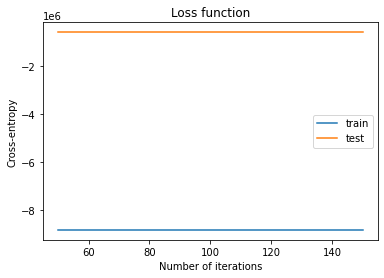

In [65]:
# Plot the loss
plt.plot(iteration_list, loss_train_list, label="train")
plt.plot(iteration_list, loss_test_list, label="test")
plt.legend()
plt.title("Loss function")
plt.xlabel("Number of iterations")
plt.ylabel("Cross-entropy")